In [11]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime
from scipy.optimize import curve_fit
import math
from scipy import asarray as ar,exp
import pylab as plb
import tqdm
from tqdm import tqdm
import time
import progressbar
import sys

In [51]:
#importing data from my other file so I'm not running over other kernels
x1_peaks = np.load("x1_peaks_file_5.npy")
x2_peaks = np.load("x2_peaks_file_5.npy")
y1_peaks = np.load("y1_peaks_file_5.npy")
y2_peaks = np.load("y2_peaks_file_5.npy")

x1_peaks_XS = np.load("x1_peaks_file_VERY_SMALL.npy")
x2_peaks_XS = np.load("x2_peaks_file_VERY_SMALL.npy")

#need the labels as well; easier to work with in an array for the 2nd step of splitting between x and y
test_labels = pd.read_pickle("test_labels_df_5")
test_labels_arr = test_labels.to_numpy()

test_data = pd.read_pickle("test_data_df_5")
test_data_arr = test_data.to_numpy()

x_label_test = test_labels_arr[ : , 0 ]
y_label_test = test_labels_arr[ : , 1 ]

x_label_test_XS = test_labels_arr[ :25 , 0 ]
x1_data_test_XS = (test_data_arr[:25 , :33])*100
x2_data_test_XS = (test_data_arr[:25, 33:66])*100

x1_data_test = (test_data_arr[: , :33])*100
x2_data_test = (test_data_arr[:, 33:66])*100
y1_data_test = (test_data_arr[:, 66:99])*100
y2_data_test = (test_data_arr[:, 99:132])*100

In [13]:
def remove_error(arr1data, arr2data, arrlabels):
    error_indices1 = np.where(arr1data == -5555 )
    error_indices2 = np.where(arr2data == -5555 )
        
    arr1data_df = pd.DataFrame(arr1data)
    arr2data_df = pd.DataFrame(arr2data)
    arrlabels_df = pd.DataFrame(arrlabels)
        
    error_indices = np.unique(np.concatenate([error_indices1, error_indices2], axis = 1))
        
    arr1data_df_fixed = arr1data_df.drop(arr1data_df.index[error_indices])
    arr2data_df_fixed = arr2data_df.drop(arr2data_df.index[error_indices])
    arrlabels_df_fixed = arrlabels_df.drop(arrlabels_df.index[error_indices])
        
    arr1data_fixed = arr1data_df_fixed.to_numpy()
    arr2data_fixed = arr2data_df_fixed.to_numpy()
    arrlabels_fixed = arrlabels_df_fixed.to_numpy()
        
    return arr1data_fixed, arr2data_fixed, arrlabels_fixed

In [14]:
#conversions from diode number to millimeters and vice versa
#might need to be updated if Yassid sends a better method of converting
def diodenum_to_mm(arr1data):
    convert = []
    for i in range(len(arr1data)):
        mm = (arr1data[i] /33)*100 - 48
        convert.append(mm)
    return np.concatenate(convert)

def mm_to_diodenum(arr1data):
    convert = []
    for i in range(len(arr1data)):
        diodenum = ((arr1data[i] + 48)/100)*33
        convert.append(diodenum)
    return np.concatenate(convert)

In [15]:
def average(arr1data, arr2data):
    avg = (arr1data + arr2data)/2
    return avg

In [47]:
#gaussian fit function
def gaussianpdf(x, k, sigma, mu):
    return k*np.exp(-(x-mu)**2/(2*sigma**2))

In [54]:
fixed_x_peaks_XS = remove_error(x1_peaks_XS, x2_peaks_XS, x_label_test_XS)

fixed_x1_peaks_XS = fixed_x_peaks_XS[0]
fixed_x2_peaks_XS = fixed_x_peaks_XS[1]
fixed_x_labels_XS = fixed_x_peaks_XS[2].reshape(-1)

x_peaks_XS = average(fixed_x1_peaks_XS, fixed_x2_peaks_XS)

x_peaks_mm_XS = diodenum_to_mm(x_peaks_XS)
print(x_peaks_mm_XS)
print(fixed_x_labels_XS)


x_data_XS = average(x1_data_test_XS,  x2_data_test_XS)

[16.65324992 14.60061502  6.28803819 16.57177884 17.36082744 17.36089121
 30.76003915 14.62747125 15.84656452 24.6089622  17.36087901 18.56806498
 17.36084208 17.3608678  16.72631323 20.89421552 28.80205469 12.51158466
  4.43802514 10.89933255 14.61139758 19.38219551 17.34966416 10.58704653
 32.72174418]
[-32.  -4. -20.   0. -40.  36.  28.  -4. -28.  16.  40.   4. -40. -40.
   0.   8.  24.  -8. -24. -12.  -4.  40.  32. -12.  32.]


In [56]:
#basic gaussian fit stuff; needs x and y inputs for all data points; index is both for the y data and for lower code
index = 2
x_x_XS = np.arange(0,33,1)
y_x_bad_XS = x_data_XS[index,:]

y_x_XS = squeeze(y_x_bad_XS)

x_peak_value_XS = ((fixed_x_labels_XS[index]+48)/100)*33
x_pred_peak_XS = x_peaks_XS[index]

print(x_peak_value_XS)
print(x_pred_peak_XS)

9.24
[17.9150526]


In [57]:
#curve fit code; bounds might be able to be played with still to improve model (specifically sigma in index 1)
#trying new stuff to better balance k based on the input data
if np.max(y_x_XS) > 20:
    kvalue = np.max(y_x_XS)-.1*(np.max(y_x_XS))
else:
    kvalue = np.max(y_x_XS)

popt, _ = curve_fit(gaussianpdf, x_x_XS, y_x_XS, bounds=(0, [kvalue,7., 33.]))
popt

array([32.84837624,  0.97940026,  9.31871139])

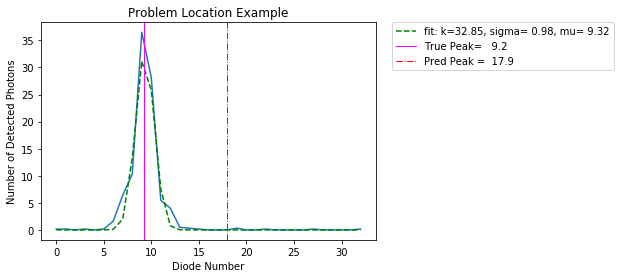

In [59]:
#having some weird problems with double brackets and stuff so this was the solution
x1plot = (x_data_XS[index, :])

plt.title('Problem Location Example')
plt.plot(x1plot)
plt.plot(x_x1, gaussianpdf(x_x1, *popt), 'g--', label='fit: k=%5.2f, sigma=%5.2f, mu=%5.2f' % tuple(popt))
plt.axvline(x = x_peak_value_XS, color = "magenta", linewidth=1, label='True Peak= %5.1f' % x_peak_value_XS)
plt.axvline(x = x_pred_peak_XS, color = "red", linewidth=1, linestyle='dashdot', label='Pred Peak = %5.1f' % x_pred_peak_XS)
plt.xlabel('Diode Number')
plt.ylabel('Number of Detected Photons')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

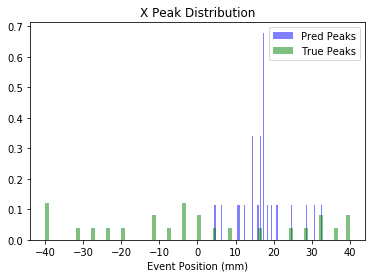

In [41]:
num_bins_x = 80
# the histogram of the data
n, bins, patches = plt.hist(x_peaks_mm_XS, num_bins_x, density=1, facecolor='blue', alpha=0.5, label = 'Pred Peaks')

#n, bins, patches = plt.hist(fixed_x2_peaks, num_bins_x, density=1, facecolor='red', alpha=0.5)

n, bins, patches = plt.hist(fixed_x_labels_XS, num_bins_x, density=1, facecolor='green', alpha=0.5, label = 'True Peaks')

plt.xlabel('Event Position (mm)')
plt.title(r'X Peak Distribution')
plt.legend()
plt.show()

In [16]:
fixed_x_peaks = remove_error(x1_peaks, x2_peaks, x_label_test)

fixed_x1_peaks = fixed_x_peaks[0]
fixed_x2_peaks = fixed_x_peaks[1]
fixed_x_labels = fixed_x_peaks[2].reshape(-1)

x_peaks = average(fixed_x1_peaks, fixed_x2_peaks)

In [17]:
x_peaks_mm = diodenum_to_mm(x_peaks)
print(x_peaks_mm)

[-15.36463063  -3.40185126 -19.90762544 ...  16.49809916 -15.92425282
   1.99992526]


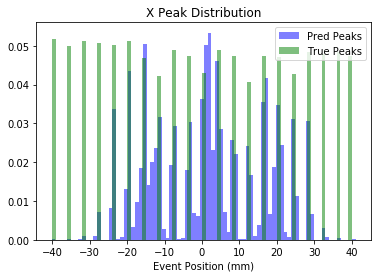

In [18]:
num_bins_x = 80
# the histogram of the data
n, bins, patches = plt.hist(x_peaks_mm, num_bins_x, density=1, facecolor='blue', alpha=0.5, label = 'Pred Peaks')

#n, bins, patches = plt.hist(fixed_x2_peaks, num_bins_x, density=1, facecolor='red', alpha=0.5)

n, bins, patches = plt.hist(fixed_x_labels, num_bins_x, density=1, facecolor='green', alpha=0.5, label = 'True Peaks')

plt.xlabel('Event Position (mm)')
plt.title(r'X Peak Distribution')
plt.legend()
plt.show()

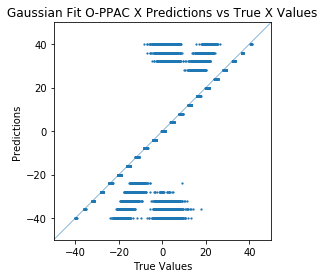

In [19]:
#graph showing the accuracy of fit by comparing predicted and true x values
#should be as close to the diagonal as possible

a = plt.axes(aspect='equal')

plt.scatter(x_peaks_mm, fixed_x_labels, s=6, marker = ".")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC X Predictions vs True X Values")
plt.show()

In [20]:
print(x_peaks_mm.shape)


#fixed_x_labels = fixed_x_labels.reshape(-1)
print(fixed_x_labels.shape)

(66268,)
(66268,)


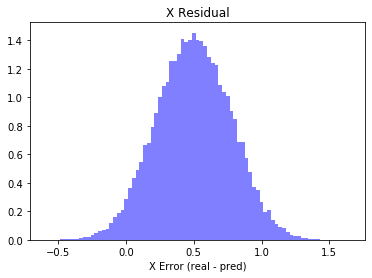

In [21]:
#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
x_error_g = x_peaks_mm - fixed_x_labels


#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
error_list_x_g = [i for i in x_error_g if abs(i) <= 5]

#print(error_list_y_g)
#error_list_x_g = np.concatenate(error_list_x_g, axis = 0)

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x_g, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')
plt.title(r'X Residual')
plt.show()

In [22]:
#to find the locations of largest error within my predicted x values
#reads through every data point from the FCNN and compares to the true value by finding the difference between the two

x_error = []
#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x_peaks.shape[0]):
    x_error_test = x_peaks[i] - fixed_x_labels[i]
    x_error.append(x_error_test)
    
x_error_fix = np.concatenate(x_error)
x_error_fix = np.array(x_error_fix)

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
xerror_list = [i for i in x_error if abs(i) >= 1]
xerror_list.sort(reverse = True)
xerror_list = np.concatenate(xerror_list, axis=0)
print(len(xerror_list))
print(xerror_list) #only uncomment if you want to see the actual error values

63432
[ 60.25019739  59.67599091  59.24971446 ... -26.50154348 -26.50945357
 -26.97420635]


In [24]:
#graph the location of areas with larger x-error; uses unshuffled data from above
bad_xvalue = 60.25019739            
x_test_locat = np.where(np.isclose(x_error_fix, bad_xvalue))
print(x_test_locat)

x_peak_value = ((x_label_test[x_test_locat[0]][0]+48)/100)*33
x_pred_peak = x_peaks[x_test_locat]

print(x_label_test[x_test_locat[0]][0])
print((x1_peaks[x_test_locat[0]][0] + x2_peaks[x_test_locat[0]][0])/2) 

(array([56506], dtype=int64),)
-16.0
10.672812692631123


In [26]:
#basic gaussian fit stuff; needs x and y inputs for all data points; index is both for the y data and for lower code
index = x_test_locat
x_x1 = np.arange(0,33,1)
y_x1_bad = x1_data_test[index,:]

y_x1 = squeeze(y_x1_bad)

print(y_x1_bad)

[[[ 0.          0.          0.          0.          0.
    0.71623885  0.35811942  1.07435827  4.2974331  11.10170216
   16.11537411 18.26409065 10.38546331 11.45982159  1.79059712
    0.35811942  0.35811942  0.          0.          0.
    0.35811942  0.35811942  0.35811942  0.          0.35811942
    0.          0.          0.          0.          0.
    0.          0.          0.        ]]]


In [27]:
#curve fit code; bounds might be able to be played with still to improve model (specifically sigma in index 1)
#trying new stuff to better balance k based on the input data
if np.max(y_x1) > 20:
    kvalue = np.max(y_x1)-.1*(np.max(y_x1))
else:
    kvalue = np.max(y_x1)

popt, _ = curve_fit(func, x_x1, y_x1, bounds=(0, [kvalue,7., 33.]))
popt

array([17.50330258,  1.74976617, 10.76045166])

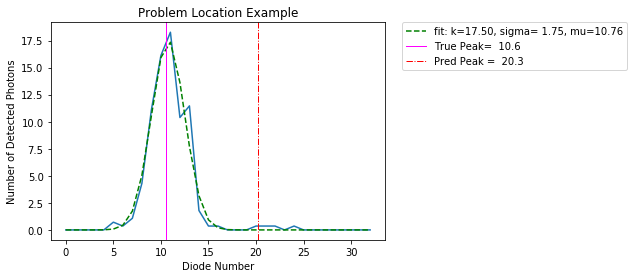

In [28]:
#having some weird problems with double brackets and stuff so this was the solution
x1plot = (x1_data_test[x_test_locat[0], :])

plt.title('Problem Location Example')
plt.plot(x1plot[0])
plt.plot(x_x1, func(x_x1, *popt), 'g--', label='fit: k=%5.2f, sigma=%5.2f, mu=%5.2f' % tuple(popt))
plt.axvline(x = x_peak_value, color = "magenta", linewidth=1, label='True Peak= %5.1f' % x_peak_value)
plt.axvline(x = x_peaks[x_test_locat], color = "red", linewidth=1, linestyle='dashdot', label='Pred Peak = %5.1f' % x_peaks[x_test_locat])
plt.xlabel('Diode Number')
plt.ylabel('Number of Detected Photons')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [29]:
#now to work on the y values

In [30]:
fixed_y_peaks = remove_error(y1_peaks, y2_peaks, y_label_test)

fixed_y1_peaks = fixed_y_peaks[0]
fixed_y2_peaks = fixed_y_peaks[1]
fixed_y_labels = fixed_y_peaks[2].reshape(-1)

y_peaks = average(fixed_y1_peaks, fixed_y2_peaks)

In [31]:
y_peaks_mm = diodenum_to_mm(y_peaks)
print(y_peaks_mm)

[-14.16430628  -7.74384386  24.71874469 ...   0.0837415    8.49993962
   0.49290926]


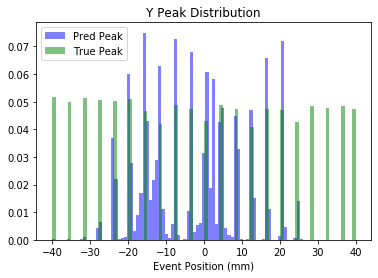

In [32]:
num_bins_x = 80
# the histogram of the data
n, bins, patches = plt.hist(y_peaks_mm, num_bins_x, density=1, facecolor='blue', alpha=0.5, label= 'Pred Peak')

#n, bins, patches = plt.hist(fixed_x2_peaks, num_bins_x, density=1, facecolor='red', alpha=0.5)

n, bins, patches = plt.hist(fixed_x_labels, num_bins_x, density=1, facecolor='green', alpha=0.5, Label = "True Peak")

plt.xlabel('Event Position (mm)')
plt.title(r'Y Peak Distribution')
plt.legend()
plt.show()

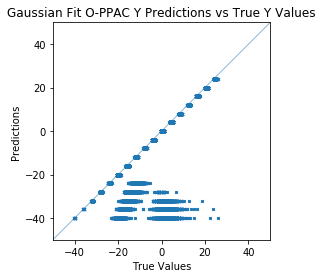

In [33]:
#graph showing the accuracy of fit by comparing predicted and true x values
#should be as close to the diagonal as possible
new_y_labels_g = []
for i in range(y_peaks.shape[0]):
    new_y_labels_g.append([y_peaks_mm[i]])
np.array(new_y_labels_g)

a = plt.axes(aspect='equal')

plt.scatter(new_y_labels_g, fixed_y_labels, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC Y Predictions vs True Y Values")
plt.show()

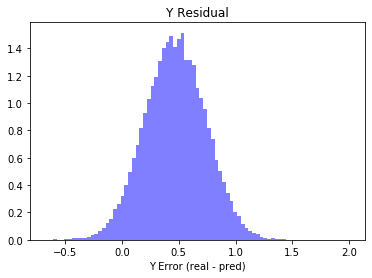

In [34]:
#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
y_error_g = y_peaks_mm - fixed_y_labels


#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
error_list_y_g = [i for i in y_error_g if abs(i) <= 5]

#print(error_list_y_g)
#error_list_y_g = np.concatenate(error_list_y_g, axis = 0)

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_y_g, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Error (real - pred)')
plt.title(r'Y Residual')
plt.show()

In [35]:
#to find the locations of largest error within my predicted x values
#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
y_error = y_peaks_mm - fixed_y_labels

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
yerror_list = [i for i in y_error if abs(i) >= 1]
yerror_list.sort(reverse = True)
print(len(yerror_list))
#print(yerror_list) #only uncomment if you want to see the actual error values

18022
